In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV
import warnings
import joblib
import os
import math
warnings.filterwarnings("ignore")

In [57]:
class GeologyML():
        def __init__(self,target,element,ley):
                self.target = target
                self.element = element
                self.ley = ley

        def Grafics_ML(self,y_train,yp):
                # Primera gráfica de líneas
                fig, ax1 = plt.subplots(figsize=(12, 6))
                t = np.arange(0, len(yp), 1)
                ax1.plot(t, yp, label='Predicciones', color='blue')
                ax1.plot(t, y_train, label='Datos reales', color='orange')
                ax1.set_ylabel(self.target)
                ax1.grid(True)
                ax1.legend()

                # Segunda gráfica de scatter plot
                fig2, ax2 = plt.subplots(figsize=(8, 8))
                ax2.scatter(y_train, yp, label='y_train vs yp', color='green', alpha=0.5)
                ax2.set_xlabel('y_train')
                ax2.set_ylabel('Predicciones')
                ax2.grid(True)
                ax2.legend()
                plt.show()

        def Assay_Limit(self,data):
                df1 = data.loc[data[self.element] >= self.ley]
                df2 = data.loc[data[self.element] < self.ley]
                return df1,df2

        def RF_Best_Params(self,X,y,search_all):
                print('Best Parameters of Random Forest Ramdomorized')
                rg = {'bootstrap': [True, False], 
                        'max_depth': [500,750,1000,None],
                        'max_features': ['auto','sqrt','log2',0.2,0.3,0.6,0.9], 
                        'min_samples_leaf': [1,2,4,16,32,64,128],
                        'min_samples_split': [2,5,10,20,40,80], 
                        'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000]}
                if search_all:
                        gsc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rg,
                                        cv=5, verbose=0, n_jobs=-1)
                else:
                        gsc = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rg, n_iter=100,
                                        cv=5, verbose=0, random_state=42,n_jobs=-1)
                grid_result = gsc.fit(X, y)
                best_params = grid_result.best_params_
                return best_params

        def RF_Scoring(self,X,y,params,root_model,name):
                rfr = RandomForestRegressor(max_depth=params["max_depth"], n_estimators=params["n_estimators"],
                                        min_samples_leaf=params["min_samples_leaf"],max_features= params["max_features"],
                                                min_samples_split=params["min_samples_split"],bootstrap=params["bootstrap"],
                                                verbose=0, warm_start=True,random_state=42,n_jobs=-1)
                print("Best Params: ",params)
                rfr.fit(X, y)
                file_model= name +'.pkl'
                file_model = os.path.join(root_model, file_model)
                joblib.dump(rfr,file_model)

                print("Scoring Analysis and Graphics")
                scoring = {'abs_error': 'neg_mean_absolute_error', 'squared_error': 'neg_mean_squared_error', 'r2': 'r2','explained_variance': 'explained_variance'}
                scores = cross_validate(rfr, X, y, cv=10, scoring=scoring, return_train_score=True)
                print("Random Forest Regression Analysis")
                print("MAE :", abs(scores['train_abs_error'].mean()), "| RMSE :",
                        math.sqrt(abs(scores['train_squared_error'].mean())),
                        "| R2 :", scores['train_r2'].mean(), "| EV :", scores['train_explained_variance'].mean())
                yp = rfr.predict(X)
                self.Grafics_ML(y, yp)


        def RF_Model(self,root,root_model):
                if self.target == 'BWI':
                        df = pd.read_excel(root)
                        df = df.sample(frac=1)
                        df1, df2  = self.Assay_Limit(df)
                        X1 = df1[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
                        y1 = df1[self.target]
                        X2 = df2[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
                        y2 = df2[self.target]
                        # X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
                        # X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

                        # Normalizar los datos
                        scaler1 = MinMaxScaler(feature_range=(0,1))
                        scaler1.fit(X1)
                        X1 = scaler1.transform(X1)
                        file_scaler1= 'scaler_rf1.pkl'
                        file_scaler1 = os.path.join(root_model, file_scaler1)
                        joblib.dump(scaler1,file_scaler1)

                        scaler2 = MinMaxScaler(feature_range=(0,1))
                        scaler2.fit(X2)
                        X2 = scaler2.transform(X2)
                        file_scaler2= 'scaler_rf2.pkl'
                        file_scaler2 = os.path.join(root_model, file_scaler2)
                        joblib.dump(scaler2,file_scaler2)
                        
                        best_params_1 = self.RF_Best_Params(X1,y1,search_all=False)
                        best_params_2 = self.RF_Best_Params(X2,y2,search_all=False)
                        
                        self.RF_Scoring(X1,y1,best_params_1,root_model,name='model_rf1')
                        self.RF_Scoring(X2,y2,best_params_2,root_model,name='model_rf2')
                
                if self.target == 'SPI':
                        df = pd.read_excel(root)
                        df = df.sample(frac=1)
                        df1, df2  = self.Assay_Limit(df)
                        X1 = df1[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%','BWI']]
                        y1 = df1[self.target]
                        X2 = df2[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%','BWI']]
                        y2 = df2[self.target]
                        # X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
                        # X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

                        # Normalizar los datos
                        scaler1 = MinMaxScaler(feature_range=(0,1))
                        scaler1.fit(X1)
                        X1 = scaler1.transform(X1)
                        file_scaler1= 'scaler_rf1.pkl'
                        file_scaler1 = os.path.join(root_model, file_scaler1)
                        joblib.dump(scaler1,file_scaler1)

                        scaler2 = MinMaxScaler(feature_range=(0,1))
                        scaler2.fit(X2)
                        X2 = scaler2.transform(X2)
                        file_scaler2= 'scaler_rf2.pkl'
                        file_scaler2 = os.path.join(root_model, file_scaler2)
                        joblib.dump(scaler2,file_scaler2)
                        
                        best_params_1 = self.RF_Best_Params(X1,y1,search_all=False)
                        best_params_2 = self.RF_Best_Params(X2,y2,search_all=False)
                        
                        self.RF_Scoring(X1,y1,best_params_1,root_model,name='model_rf1')
                        self.RF_Scoring(X2,y2,best_params_2,root_model,name='model_rf2')

In [ ]:
root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/BWI/BWI_1ley/'
target = 'BWI'
g = GeologyML(target,element='Na%',ley=1)
g.RF_Model(root,root_model)

Best Parameters of Random Forest Ramdomorized
Best Parameters of Random Forest Ramdomorized
Best Params:  {'n_estimators': 1200, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 2.1164314980947334 | RMSE : 2.6919144620755993 | R2 : 0.1687054002848556 | EV : 0.16871368700842007


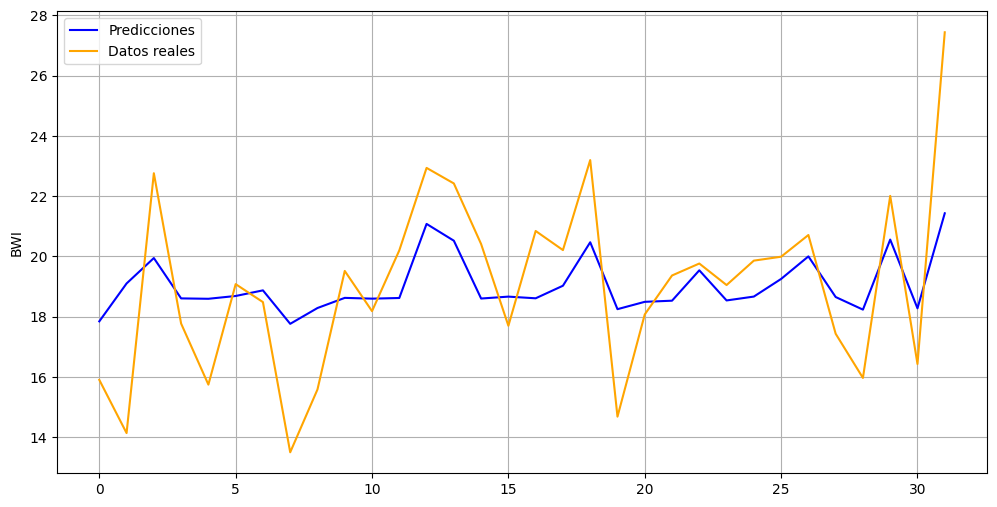

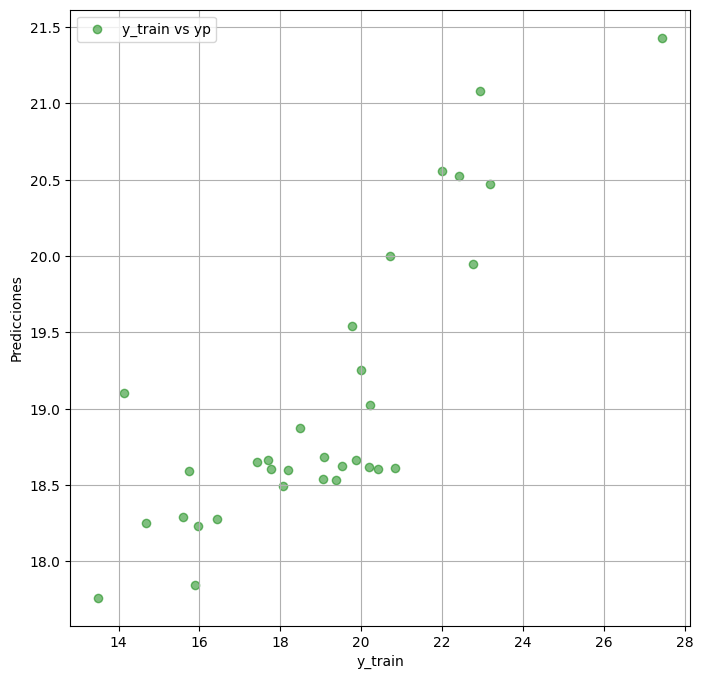

Best Params:  {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.9, 'max_depth': 500, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 1.0561981674912762 | RMSE : 1.4049453526001388 | R2 : 0.726469197964825 | EV : 0.7264804671953584


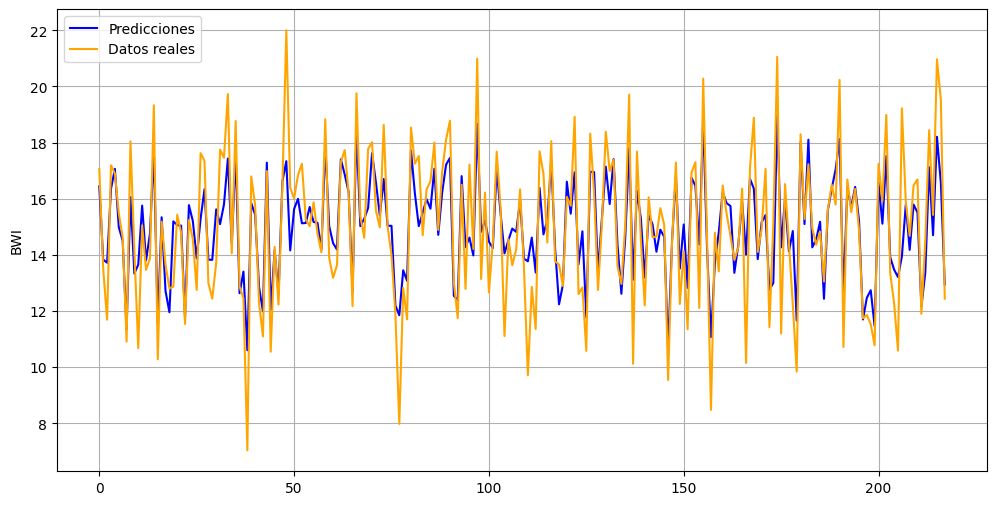

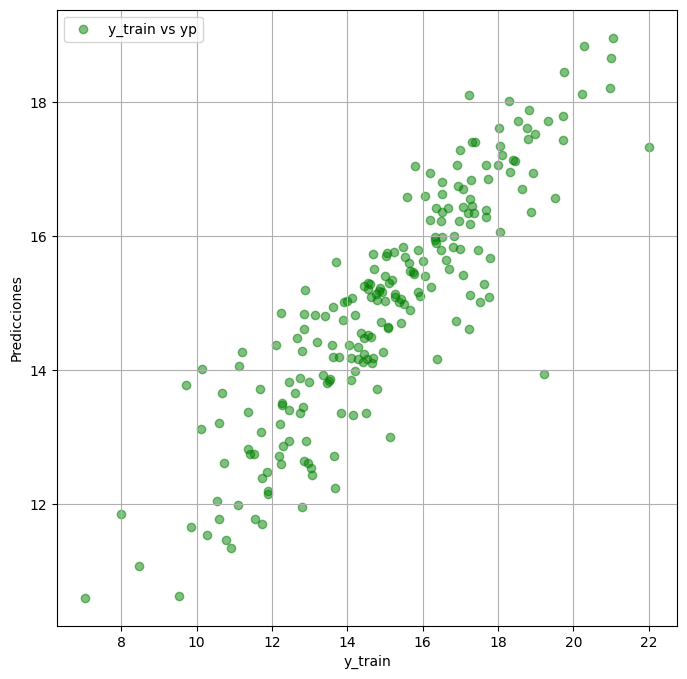

In [142]:
# root = '../03_BBDD/data_dureza_train.xlsx'
# root_model = '../04_Model/Hardness/BWI/BWI_1ley/'
# target = 'BWI'
# g = GeologyML(target,element='Na%',ley=1)
# g.RF_Model(root,root_model)

Best Parameters of Random Forest Ramdomorized
Best Parameters of Random Forest Ramdomorized
Best Params:  {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': 500, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 12.02463598744377 | RMSE : 15.64916629264727 | R2 : 0.8379633184775953 | EV : 0.8380288224960821


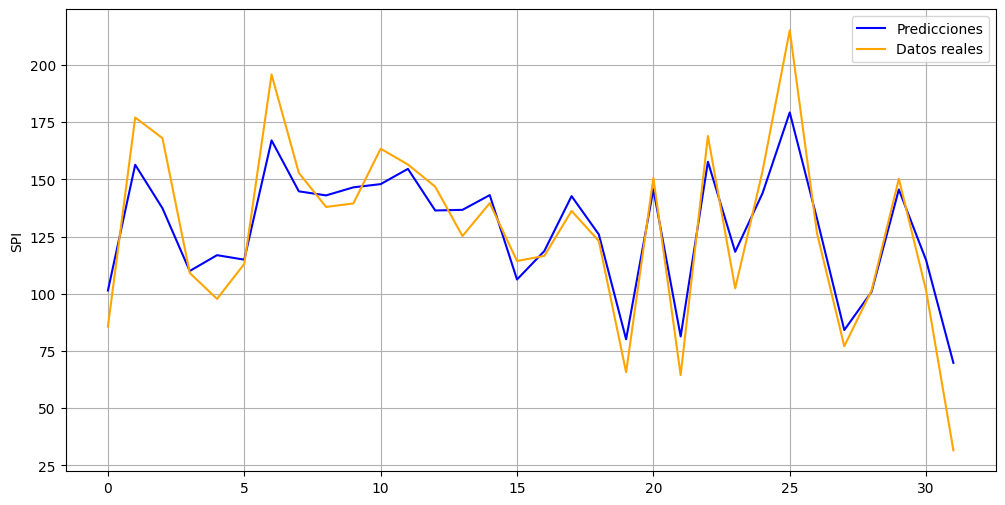

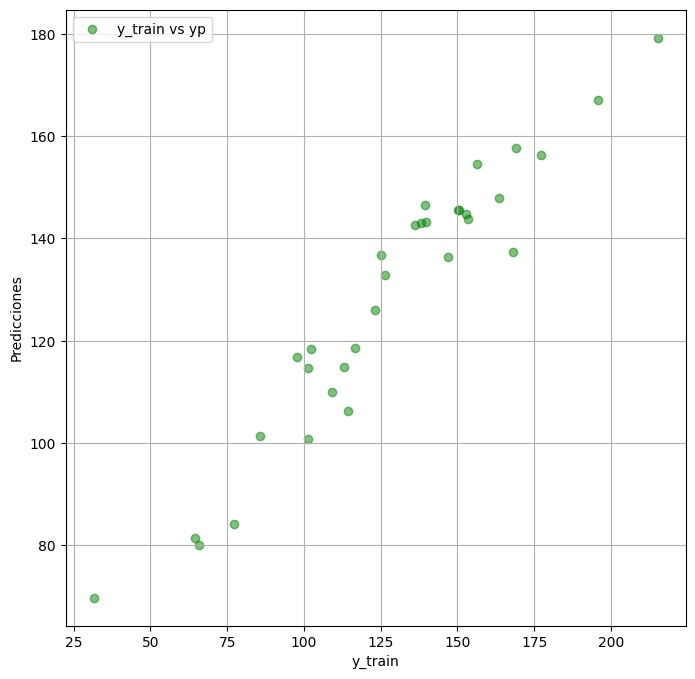

Best Params:  {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': 500, 'bootstrap': True}
Scoring Analysis and Graphics
Random Forest Regression Analysis
MAE : 8.007397584763703 | RMSE : 10.37680140721388 | R2 : 0.8927026472187933 | EV : 0.8927061420058452


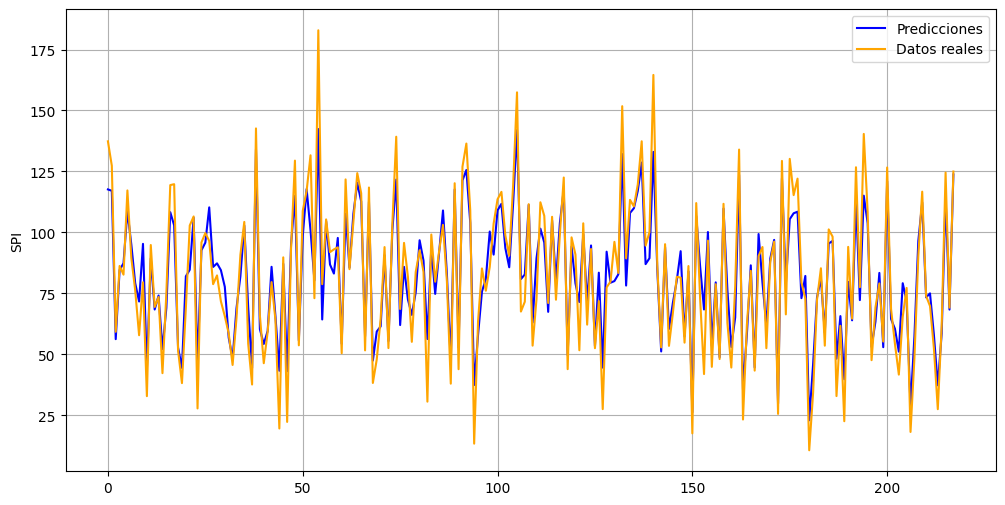

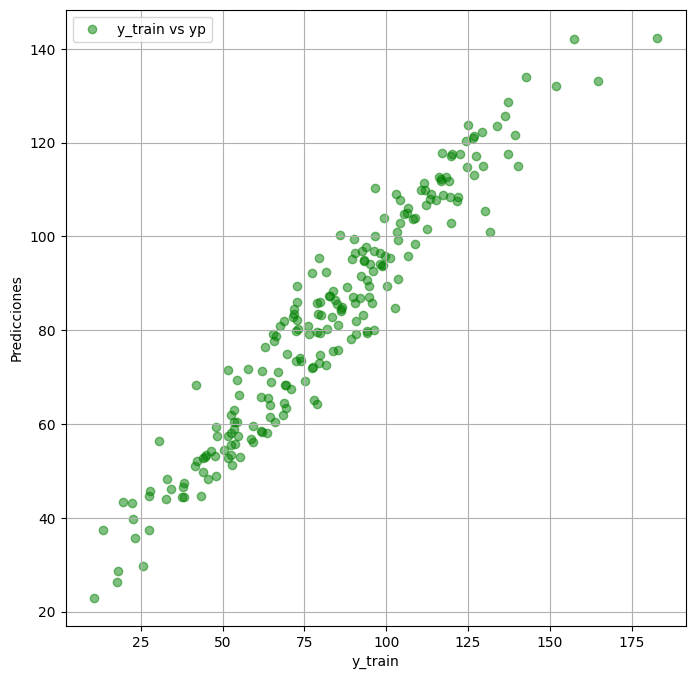

In [62]:
root = '../03_BBDD/data_dureza_train.xlsx'
root_model = '../04_Model/Hardness/SPI/SPI_1ley/'
target = 'SPI'
g = GeologyML(target,element='Na%',ley=1)
g.RF_Model(root,root_model)

In [7]:
class GeologyML():
        def __init__(self,target,element,ley):
                self.target = target
                self.element = element
                self.ley = ley

        def Grafics_ML(self,y_train,yp):
                # Primera gráfica de líneas
                fig, ax1 = plt.subplots(figsize=(12, 6))
                t = np.arange(0, len(yp), 1)
                ax1.plot(t, yp, label='Predicciones', color='blue')
                ax1.plot(t, y_train, label='Datos reales', color='orange')
                ax1.set_ylabel(self.target)
                ax1.grid(True)
                ax1.legend()

                # Segunda gráfica de scatter plot
                fig2, ax2 = plt.subplots(figsize=(8, 8))
                ax2.scatter(y_train, yp, label='y_train vs yp', color='green', alpha=0.5)
                ax2.set_xlabel('y_train')
                ax2.set_ylabel('Predicciones')
                ax2.grid(True)
                ax2.legend()
                plt.show()

        def Assay_Limit(self,data):
                df1 = data.loc[data[self.element] >= self.ley]
                df2 = data.loc[data[self.element] < self.ley]
                return df1,df2

        def SV_Best_Params(self,X,y,search_all):
                print('Best Parameters of Random Forest Ramdomorized')
                rg= {
                'C': [0.01,0.1, 1, 5,10, 50,100,1000],
                'epsilon': [0.001,0.01, 0.05, 0.1,0.2,0.5,1,10],
                'gamma': [0.001, 0.01, 0.1, 1,10],
                'kernel' : ['rbf','linear']}
                
                if search_all:
                        gsc = GridSearchCV(estimator=SVR(), param_grid=rg,
                                        cv=5, verbose=0, n_jobs=-1)
                else:
                        gsc = RandomizedSearchCV(estimator=SVR(), param_distributions=rg, n_iter=100,
                                        cv=5, verbose=0, random_state=42,n_jobs=-1)
                grid_result = gsc.fit(X, y)
                best_params = grid_result.best_params_
                return best_params

        def SV_Scoring(self,X,y,params,root_model,name):
                rfr = SVR(kernel=params['kernel'],C=params['C'],epsilon=params['epsilon'],gamma=params['gamma'])
                print("Best Params: ",params)
                rfr.fit(X, y)
                file_model= name +'.pkl'
                file_model = os.path.join(root_model, file_model)
                joblib.dump(rfr,file_model)

                print("Scoring Analysis and Graphics")
                scoring = {'abs_error': 'neg_mean_absolute_error', 'squared_error': 'neg_mean_squared_error', 'r2': 'r2','explained_variance': 'explained_variance'}
                scores = cross_validate(rfr, X, y, cv=10, scoring=scoring, return_train_score=True)
                print("Random Forest Regression Analysis")
                print("MAE :", abs(scores['train_abs_error'].mean()), "| RMSE :",
                        math.sqrt(abs(scores['train_squared_error'].mean())),
                        "| R2 :", scores['train_r2'].mean(), "| EV :", scores['train_explained_variance'].mean())
                yp = rfr.predict(X)
                self.Grafics_ML(y, yp)


        def SV_Model(self,root,root_model):
                df = pd.read_excel(root)
                df = df.sample(frac=1)
                df1, df2  = self.Assay_Limit(df)
                X1 = df1[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
                y1 = df1[self.target]
                X2 = df2[['Cu%', 'Mo%','AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
                y2 = df2[self.target]
                # X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
                # X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

                # Normalizar los datos
                scaler1 = MinMaxScaler(feature_range=(0,1))
                scaler1.fit(X1)
                X1 = scaler1.transform(X1)
                file_scaler1= 'scaler_rf1.pkl'
                file_scaler1 = os.path.join(root_model, file_scaler1)
                joblib.dump(scaler1,file_scaler1)

                scaler2 = MinMaxScaler(feature_range=(0,1))
                scaler2.fit(X2)
                X2 = scaler2.transform(X2)
                file_scaler2= 'scaler_rf2.pkl'
                file_scaler2 = os.path.join(root_model, file_scaler2)
                joblib.dump(scaler2,file_scaler2)
                
                # best_params_1 = self.RF_Best_Params(X1,y1,search_all=False)
                best_params_2 = self.SV_Best_Params(X2,y2,search_all=True)
                
                #self.RF_Scoring(X1,y1,best_params_1,root_model,name='model_rf1')
                self.SV_Scoring(X2,y2,best_params_2,root_model,name='model_rf2')

In [132]:
import os
import pandas as pd
import joblib

class RF_predict():
    def __init__(self,target1,target2,root,root_model_spi,root_model_bwi):
        self.target1 = target1 #target1 is BWI
        self.target2 = target2 # target2 is SPI
        self.root = root
        self.root_model_spi = root_model_spi
        self.root_model_bwi = root_model_bwi

    def BWI_Predict(self): 
        def Model_1(x):
            file_model = 'model_rf1.pkl'
            file_model = os.path.join(self.root_model_bwi, file_model)
            file_scaler = 'scaler_rf1.pkl'
            file_scaler = os.path.join(self.root_model_bwi, file_scaler)
            scaler_s = joblib.load(file_scaler) 
            model_s = joblib.load(file_model)
            x_test = scaler_s.transform(x)
            y_pred = model_s.predict(x_test)
            return y_pred

        def Model_2(x):
            file_model = 'model_rf2.pkl'
            file_model = os.path.join(self.root_model_bwi, file_model)
            file_scaler = 'scaler_rf2.pkl'
            file_scaler = os.path.join(self.root_model_bwi, file_scaler)
            scaler_s = joblib.load(file_scaler) 
            model_s = joblib.load(file_model)
            x_test = scaler_s.transform(x)
            y_pred = model_s.predict(x_test)
            return y_pred
        
        def Use_Model_RF(element,ley):
            #For BWI
            df = pd.read_excel(self.root)[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
            mask = df[element] >= ley
            df_filtered = df[mask]
            x_model1 = df_filtered[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
            result_model1 = Model_1(x_model1)*0.9
            df.loc[mask, self.target1] = result_model1
            df_not_filtered = df[~mask]
            x_model2 = df_not_filtered[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%']]
            result_model2 = Model_2(x_model2)*0.92
            df.loc[~mask, self.target1] = result_model2
            #BWI
            #Model_1 factor 0.90
            #Model_2 facotr 0.92
            return df
        
        db = Use_Model_RF(element='Na%',ley=1.0)
        return db
    
    def SPI_Predict(self): 
        def Model_1(x):
            file_model = 'model_rf1.pkl'
            file_model = os.path.join(self.root_model_spi, file_model)
            file_scaler = 'scaler_rf1.pkl'
            file_scaler = os.path.join(self.root_model_spi, file_scaler)
            scaler_s = joblib.load(file_scaler) 
            model_s = joblib.load(file_model)
            x_test = scaler_s.transform(x)
            y_pred = model_s.predict(x_test)
            return y_pred

        def Model_2(x):
            file_model = 'model_rf2.pkl'
            file_model = os.path.join(self.root_model_spi, file_model)
            file_scaler = 'scaler_rf2.pkl'
            file_scaler = os.path.join(self.root_model_spi, file_scaler)
            scaler_s = joblib.load(file_scaler) 
            model_s = joblib.load(file_model)
            x_test = scaler_s.transform(x)
            y_pred = model_s.predict(x_test)
            return y_pred
        
        def Use_Model_RF(element,ley):
            #For SPI
            df = self.BWI_Predict()[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%','BWI']]
            mask = df[element] >= ley
            df_filtered = df[mask]
            x_model1 = df_filtered[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%','BWI']]
            result_model1 = Model_1(x_model1)*1.18
            df.loc[mask, self.target2] = result_model1
            df_not_filtered = df[~mask]
            x_model2 = df_not_filtered[['Cu%', 'Mo%', 'AgPPM', 'AuPPM', 'Al%', 'Ca%', 'Fe%', 'Mg%', 'Na%', 'S%','BWI']]
            result_model2 = Model_2(x_model2)*0.97
            df.loc[~mask, self.target2] = result_model2
            #SPI
            #Model_1 factor 
            #Model_2 facotr 
            return df
        df = Use_Model_RF(element='Na%',ley=1.0)
        return df  



0    18.582246
1    18.582246
2    18.582246
3    18.582246
4    18.582246
5    18.579211
6    18.582246
7    18.582246
8    18.574877
9    18.599679
Name: BWI, dtype: float64
count    106153.000000
mean         17.568291
std           1.157339
min          11.266992
25%          17.438695
50%          17.788139
75%          18.106546
max          19.270814
Name: BWI, dtype: float64


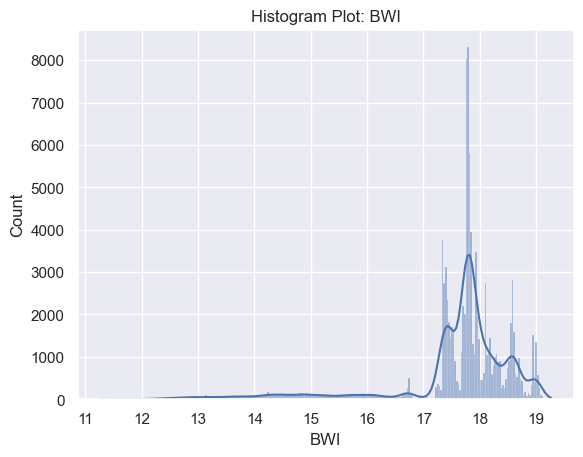

In [134]:
target1 = 'BWI'
target2 = 'SPI'
root = '../03_BBDD/bwilt23.3.xlsx'
root_model_bwi = '../04_Model/Hardness/BWI/BWI_1ley/'
root_model_spi = '../04_Model/Hardness/SPI/SPI_1ley/'

g = RF_predict(target1,target2,root,root_model_spi,root_model_bwi)
k = g.SPI_Predict()
k
print(k[target1].head(10))
print(k.describe()[target1])
sns.set_theme()
sns.histplot(k[target1],kde=True)
plt.title(f'Histogram Plot: {target1}')
plt.show()


***SPI***

In [ ]:
from User import user_class
user_class().Generate_Model(root='../03_BBDD/data_dureza_train.xlsx')
user_class().Generate_Model(root='../03_BBDD/data_dureza_train.xlsx',root_bbdd='../03_BBDD/Resultados_Dureza.xlsx')

Best Parameters of Random Forest Ramdomorized
